# Multiple objective land allocation (MOLA)

This notebook present an example of a MOLA analysis using python. We set up the problem as a linear programming optimization problem and solve it. This example is based on dataset describing temperature and distance to green infrastructure. The goal is to select location (parcels) that maximize temperature and distance from green location to mitigate urban heat and provide new green infrastructure. This is part of Tijana Jovanovic project at SESYNC.

In [395]:
############### SESYNC Research Support: Urban green planning ########## 
## Testing optimization.
## 
##
## DATE CREATED: 11/15/2018
## DATE MODIFIED: 12/11/2018
## AUTHORS: Benoit Parmentier, Tijana Jovanovic  
## Version: 1
## PROJECT: Urban green infrastructure planning
## ISSUE: 
## TO DO:
##
## COMMIT: clean up
##

###################################################
#

###### Library used

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import scipy
from math import cos
import cvxpy

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
in_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/Data"
#in_dir <- "/nfs/tjovanovic-data/Data/Baltimore/Hydrology/GAstart"
#ARGS 2
out_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "mola_baltimore_example_12032018" #output suffix for the files and ouptut folder
#ARGS 5
num_cores = 2 # number of cores
#ARGS 6
file_format = ".csv"
#ARGS 7
create_out_dir==True

#dem_baltimore_filename = "DEM_BaltArea_1m.tif"
#lc_baltimore_filename = "landCover_area1m.tif"
#reg_outline_filename = "watersheds8digit.shp"

################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier
print(os.getcwd())

/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs/output_data_mola_baltimore_example_12032018


In [397]:
#######################################
### PART 1: Read in DATA #######

in_filename_data = "Vacant_distanceTemperature.csv"

data_df = pd.read_csv(os.path.join(in_dir,in_filename_data))
print(data_df.size,
      data_df.shape)

data_df.head()


8725 (1745, 5)


,FID,OBJECTID,BLOCKLOT,DISTANCE,TEMPERATURE
0,0,666179,3438B002B,0.018812,0.582045
1,1,666200,1158 080,0.010489,0.554612
2,2,666208,3804 017,0.014795,0.532371
3,3,666212,4114C029,0.013429,0.590748
4,4,666224,1144 004,0.010189,0.508618


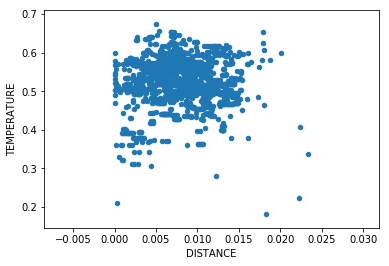

In [398]:
data_df.plot.scatter(x='DISTANCE',y='TEMPERATURE')

In [399]:
#Let's rescale ("normalize") the data.
data_df[data_df['DISTANCE']==data_df['DISTANCE'].max()]

#rescaled_val= (data_df['DISTANCE'] -data_df['DISTANCE'].min())/(data_df['DISTANCE'].max()-data_df['DISTANCE'].min())
type(rescaled_val)
#print(rescaled_val.max(),rescaled_val.min())
#rescaled_val.head()
##Normalized distance
data_df['DISTANCE_n']= (data_df['DISTANCE'] -data_df['DISTANCE'].min())/(data_df['DISTANCE'].max()-data_df['DISTANCE'].min())



In [400]:
f_combined = data_df['DISTANCE_n'] + data_df['TEMPERATURE']
type(f_combined)
f_combined.head()

0    1.386210
1    1.003003
2    1.164823
3    1.164792
4    0.944170
dtype: float64

In [401]:
factor_combined=f_combined.as_matrix()
type(factor_combined)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [402]:
from pulp import *
import numpy as np

number_of_objectives = 2
number_of_locations = 1745
#n_pix = number_of_objectives*number_of_locations
n_loc = 1745

locations=['location_%d'%i for i in range(n_loc)] # for spatial application: locations,parcels or pixels to select 

#variables. How many of each object to take. For simplicity lets make this 0 or 1 (classic 0-1 knapsack problem)
#x1 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision var for ski objective
#x2 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision for habitat objection
x = LpVariable.dicts('location',locations,0,1, LpBinary) #decision for habitat objection

#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))
val = dict(zip(locations,factor_combined))
            
D=200 
#select 200 locations correspond to Weight in Knapsack 0-1

#create the problme
prob2=LpProblem("knapsack",LpMaximize)


In [403]:
list_obj= [val[i]*x[i] for i in locations]

#cost1 = lpSum([ val1[i]*x1[i] for i in pixels]) # suitability sum ojb1
#cost2 = lpSum([ val2[i]*x2[i] for i in pixels]) # suitability sum ojb2

cost = lpSum(list_obj)
#prob+=cost
#prob+=cost1
#prob+=cost2
prob2+=cost

#Demand constraint
#pixel_weights = np.ones(20)
location_weights = dict(zip(locations,np.ones(n_loc).T))
#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))

#list_constraint1 = [pixel_weights[i]*x1[i] for i in pixels]
#list_constraint2 = [pixel_weights[i]*x2[i] for i in pixels]
#print(location_weights[1])

In [404]:
list_constraint = [location_weights[i]*x[i] for i in locations]
prob2 += lpSum(list_constraint) <= D #demand for ski resort

#print(prob2)

%time prob2.solve()
print(LpStatus[prob2.status])


CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 131 ms
Optimal


In [405]:

bool_val = []
for i in locations:
    tmp_val =value(x[i])
    #print(i, value(x[i]))
    bool_val.append(tmp_val)

data_df['f_combined'] = f_combined
data_df['selection']=bool_val

data_df.head()

,FID,OBJECTID,BLOCKLOT,DISTANCE,TEMPERATURE,DISTANCE_n,f_combined,selection
0,0,666179,3438B002B,0.018812,0.582045,0.804164,1.386210,1.0
1,1,666200,1158 080,0.010489,0.554612,0.448391,1.003003,0.0
2,2,666208,3804 017,0.014795,0.532371,0.632452,1.164823,1.0
3,3,666212,4114C029,0.013429,0.590748,0.574044,1.164792,1.0
4,4,666224,1144 004,0.010189,0.508618,0.435552,0.944170,0.0


In [406]:
sum(bool_val) #Ok sum is matching the demand

200.0

In [407]:
#Generate 3D plot here

In [408]:
out_filename = "vacant_land_selection_" + out_suffix +'.csv'
out_filename=os.path.join(out_dir,out_filename)
data_df.to_csv(out_filename)

In [ ]:
############################ END OFS SCRIPT ############################